# 1.0 Purpose
The purpose of this notebook is to use Embedding for a Natural Language Processing (NLP) task with TensorFlow on the Text Generation from Eminem.

# 2.0 Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
print(tf.__version__)

2.5.0


## Helper Functions

### decode_review

In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])



### get_training_metrics

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

### plot_train_eval

In [ ]:
def plot_train_eval(history,name='',parameters='',optimizer_name='',loss='',accuracy_metric='',epochs='',vocab_size='',embedding_dim='',max_length='',trunc_type='',oov_tok=''):
  acc, val_acc, loss_values, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n optimizer_name={optimizer_name} \n loss={loss} \n accuracy_metric={accuracy_metric} \n epochs={epochs} \n vocab_size={vocab_size} \n embedding_dim={embedding_dim} \n max_length={max_length} \n trunc_type={trunc_type} \n oov_tok={oov_tok}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel(accuracy_metric)
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss_values, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n optimizer_name={optimizer_name}  \n loss={loss} \naccuracy_metric={accuracy_metric} \n epochs={epochs} \n vocab_size={vocab_size} \n embedding_dim={embedding_dim} \n max_length={max_length} \n trunc_type={trunc_type} \n oov_tok={oov_tok}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel(loss)
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()

### model_picker

In [ ]:
def model_picker(vocab_size=100,embedding_dim=16,input_length=100,model_name='model1',rnn_units=1024,max_sequence_len=100):

  if model_name=='model1':
    model = tf.keras.Sequential([
                                tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_len-1),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
                                tf.keras.layers.Dense(vocab_size,activation='softmax')
    ])
    model_description=f'Embedding(vocab_size={vocab_size}, \n embedding_dim={embedding_dim}, \n input_length={max_length}), \n GRU({rnn_units},return_sequence=True,stateful=True,recurrent_initializer=glorot_uniform) \n Flatten, \n Dense({vocab_size},softmax)'
  return model,model_description

### loss_picker

In [ ]:
def loss_picker(loss_name='categorical_crossentropy'):

  if loss_name=='categorical_crossentropy':
    loss='categorical_crossentropy'
  return loss

# 3.0 Import Eminem Lyrics dataset from Kaggle

## 3.0.1 [Find your Kaggle Account and click the **Create New API Token** to download the json file](https://www.kaggle.com/stevensmiley/account?isEditing=False)

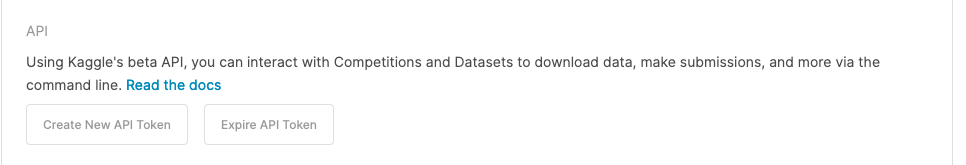

## 3.0.2 **Upload** kaggle.json file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## 3.0.3 Pick the **kaggle.json** file from your Kaggle download

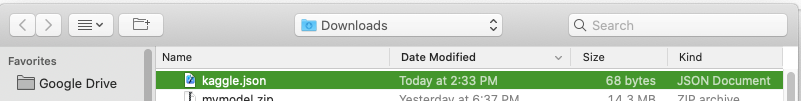

## 3.0.4 install kaggle with pip

In [ ]:
! pip install -q kaggle

## 3.0.5 create kaggle directory

In [ ]:
! mkdir ~/.kaggle 

## 3.0.6 copy the kaggle.json file to the kaggle directory

In [ ]:
! cp kaggle.json ~/.kaggle/

## 3.0.7 Set 600 permissions to a kaggle.json file so you (owner) has full read and write access to the file, while no other user can access the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## 3.0.8 List the kaggle datasets

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-14 06:30:31           7447  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4514  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1527  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2210  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

## 3.0.9 download the dataset

In [ ]:
!kaggle datasets download -d thaddeussegura/eminem-lyrics-from-all-albums

  0% 0.00/782k [00:00<?, ?B/s]
100% 782k/782k [00:00<00:00, 84.1MB/s]


## 3.0.9 Create **train** directory

In [ ]:
! mkdir train

## 3.0.10 Create **test** directory

In [ ]:
! mkdir test

## 3.0.11 **new_dir** 
helper function for making directories

In [ ]:
def new_dir(path):
  try:
    os.mkdir(path)
  except:
    print(f'Already have: {path}')
    pass

## 3.0.12 get_training_metrics
helper function for getting history metrics

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

## 3.0.13 plot_train_eval
helper function for plotting history metrics

In [ ]:
def plot_train_eval(history,name='',parameters='',num_images_per_epoch_train='',num_images_per_epoch_val='',batch_size=''):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('binary_crossentropy')
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()






In [ ]:
cols=['filename','model_name',
      'optimizer',
      'loss',
      'accuracy_metric',
      'batch_size','img_size',
      'steps_per_epoch','epochs','validation_steps',
      'num_images_per_epoch_train','num_images_per_epoch_val',
      'data_augmentation',
      'F1_score_dog','F1_score_cat',
      'Precision_dog','Precision_cat',
      'Recall_dog','Recall_cat',
      'misclassified_dogs','misclassified_cats']
df_metrics=pd.DataFrame(columns=cols)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats


In [ ]:
!unzip eminem-lyrics-from-all-albums.zip  

Archive:  eminem-lyrics-from-all-albums.zip
  inflating: eminem_lyrics/ALL_eminem.txt  
  inflating: eminem_lyrics/eminem_25tolife.txt  
  inflating: eminem_lyrics/eminem_313.txt  
  inflating: eminem_lyrics/eminem_3am.txt  
  inflating: eminem_lyrics/eminem_97bonnieandclyde.txt  
  inflating: eminem_lyrics/eminem_almostfamous.txt  
  inflating: eminem_lyrics/eminem_amityville.txt  
  inflating: eminem_lyrics/eminem_arose.txt  
  inflating: eminem_lyrics/eminem_asshole.txt  
  inflating: eminem_lyrics/eminem_asslikethat.txt  
  inflating: eminem_lyrics/eminem_astheworldturns.txt  
  inflating: eminem_lyrics/eminem_baby.txt  
  inflating: eminem_lyrics/eminem_backstabber.txt  
  inflating: eminem_lyrics/eminem_badguy.txt  
  inflating: eminem_lyrics/eminem_badhusband.txt  
  inflating: eminem_lyrics/eminem_badmeetsevil.txt  
  inflating: eminem_lyrics/eminem_bagpipesfrombaghdad.txt  
  inflating: eminem_lyrics/eminem_ballinuncontrollably.txt  
  inflating: eminem_lyrics/eminem_beautiful

In [ ]:
f=open('/content/eminem_lyrics/ALL_eminem.txt','r')
data=f.read()
f.close()

In [ ]:
data

'Look, I was gonna go easy on you not to hurt your feelings\nBut I\'m only going to get this one chance\n(Six minutes, six minutes)\nSomething\'s wrong, I can feel it\n(Six minutes, six minutes, Slim Shady, you\'re on)\nJust a feeling I\'ve got\nLike something\'s about to happen\nBut I don\'t know what\nIf that means, what I think it means, we\'re in trouble\nBig trouble. And if he is as bananas as you say\nI\'m not taking any chances\nYou are just what the doc ordered\n\nI\'m beginning to feel like a Rap God, Rap God\nAll my people from the front to the back nod, back nod\nNow who thinks their arms are long enough to slap box, slap box?\nThey said I rap like a robot, so call me rap-bot\n\nBut for me to rap like a computer must be in my genes\nI got a laptop in my back pocket\nMy pen\'ll go off when I half-cock it\nGot a fat knot from that rap profit\nMade a living and a killing off it\nEver since Bill Clinton was still in office\nWith Monica Lewinsky feeling on his nutsack\nI\'m an MC

In [ ]:
tokenizer = Tokenizer()
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'i': 1, 'the': 2, 'you': 3, 'to': 4, 'and': 5, 'a': 6, 'my': 7, 'me': 8, "i'm": 9, 'it': 10, 'in': 11, 'of': 12, 'that': 13, 'like': 14, 'on': 15, 'this': 16, 'but': 17, 'just': 18, 'your': 19, 'with': 20, 'so': 21, 'up': 22, 'is': 23, "don't": 24, 'for': 25, 'be': 26, "it's": 27, 'get': 28, 'what': 29, 'all': 30, 'we': 31, 'when': 32, 'no': 33, 'out': 34, 'at': 35, 'got': 36, 'was': 37, 'they': 38, 'shit': 39, "'cause": 40, 'know': 41, 'back': 42, 'if': 43, 'do': 44, 'now': 45, 'as': 46, 'can': 47, "you're": 48, 'go': 49, "ain't": 50, 'fuck': 51, 'one': 52, 'not': 53, 'from': 54, 'see': 55, 'say': 56, 'never': 57, 'her': 58, 'yeah': 59, 'off': 60, 'he': 61, 'have': 62, 'eminem': 63, 'man': 64, 'how': 65, 'bitch': 66, 'are': 67, 'oh': 68, 'or': 69, "that's": 70, 'think': 71, 'who': 72, 'down': 73, "can't": 74, 'his': 75, 'an': 76, 'time': 77, 'make': 78, 'then': 79, 'come': 80, "'em": 81, 'why': 82, "i'll": 83, 'wanna': 84, 'him': 85, 'some': 86, 'too': 87, 'take': 88, 'she': 89, 'bee

In [ ]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])

In [ ]:
input_sequences[0:2] #notice no padding

[[116, 1], [116, 1, 37]]

In [ ]:

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(tokenizer.word_index['gangsta'])
print(tokenizer.word_index['slim'])

2702
202


In [ ]:
len(set(tokenizer.word_index)) + 1

13723

In [ ]:
len(input_sequences[0]),max_sequence_len

(69, 69)

In [ ]:
input_sequences[0:2] #notice the pre padding

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 116,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 116,   1,  37]], dtype=int32)

# 4.1 model1 

## Set Embedding Parameters

In [ ]:
filename='TF_LSTM_GRU_NLP_TextGeneration.ipynb'
model_name='model1'
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer_name=str(optimizer)
loss_name='categorical_crossentropy'
accuracy_metric='accuracy'
epochs=20
vocab_size = total_words
embedding_dim = 256
max_length = 100
trunc_type='pre'
oov_tok = '<OOV>'
rnn_units=1024

## Create Model

In [ ]:
loss=loss_picker(loss_name=loss_name)

In [ ]:
model1,model_description=model_picker(vocab_size=vocab_size,embedding_dim=embedding_dim,input_length=max_length,model_name=model_name,rnn_units=rnn_units,max_sequence_len=max_sequence_len)

In [ ]:
model1.compile(optimizer=optimizer, loss=loss,metrics=[accuracy_metric])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 100)           1372300   
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 13723)             4130623   
Total params: 5,804,123
Trainable params: 5,804,123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
xs.shape

(160027, 68)

In [ ]:
ys.shape

(160027, 13723)

In [ ]:
history1 = model1.fit(xs,ys, epochs=epochs,verbose=1)

Epoch 1/20
5001/5001 [==============================] - 116s 22ms/step - loss: 6.4613 - accuracy: 0.0910
Epoch 2/20
5001/5001 [==============================] - 111s 22ms/step - loss: 5.7957 - accuracy: 0.1235
Epoch 3/20
5001/5001 [==============================] - 111s 22ms/step - loss: 5.3631 - accuracy: 0.1363
Epoch 4/20
5001/5001 [==============================] - 112s 22ms/step - loss: 5.0986 - accuracy: 0.1443
Epoch 5/20
5001/5001 [==============================] - 112s 22ms/step - loss: 4.9572 - accuracy: 0.1493
Epoch 6/20
5001/5001 [==============================] - 112s 22ms/step - loss: 4.8698 - accuracy: 0.1531
Epoch 7/20
5001/5001 [==============================] - 112s 22ms/step - loss: 4.8222 - accuracy: 0.1566
Epoch 8/20
5001/5001 [==============================] - 111s 22ms/step - loss: 4.7890 - accuracy: 0.1577
Epoch 9/20
5001/5001 [==============================] - 111s 22ms/step - loss: 4.7853 - accuracy: 0.1576
Epoch 10/20
5001/5001 [==============================] 

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

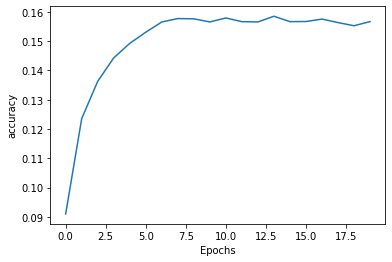

In [ ]:
plot_graphs(history1, 'accuracy')

In [ ]:
seed_text = "What is my next 100 words?"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model1.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


What is my next 100 words? you can be a backstabber trip vacation plans a city i just to the word to the word to the word to the word to the word to the word to the word to the word to the word to the word to the word to the word to the fire to the death i just to the fire to the mall roads bizarre's degenerate's spirits there'll earring dylan scary icy boi freestyles fighter warhead schnopps baa tate icy 'cause fumes 'very' vicodin dixie dresden cds fumes causin fisted moody in kaw practical blackenin' cds fumes 'very' gobble dripping of


In [ ]:
model1.save(model_name) #save model
model1=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


# 5.0 Export Models

In [ ]:
!zip -r /content/model1.zip /content/model1

  adding: content/model1/ (stored 0%)
  adding: content/model1/keras_metadata.pb (deflated 89%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model1/saved_model.pb (deflated 90%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.index (deflated 64%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 11%)


# Install **rclone**
This is so you can save your checkpoints weights to your actual google drive for restoration.

In [ ]:
! curl https://rclone.org/install.sh | sudo bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4491  100  4491    0     0   6888      0 --:--:-- --:--:-- --:--:--  6877
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    15  100    15    0     0     23      0 --:--:-- --:--:-- --:--:--    23
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0  7386k      0  0:00:01  0:00:01 --:--:-- 7382k
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/rclone.1  [text]  
  inflating:

You want to create a remote configuration with rclone.  Use the default recommendations.

In [47]:
!rclone config

2021/06/14 12:46:00 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> remote
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Providers including AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, and Tencent COS
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Compress a remote
   \ "compress"
10 / Dropbox
   \ "dropbox"
11 / Encrypt/Decrypt a remote
   \ "crypt"
12 / Enterprise File Fabric
   \ "filefabric"
13 / FTP Connection
   \ "ftp"
14 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud sto

# Copy Content to **Google Drive** with **rclone**
Try to copy exisiting weights to a future directory to ensure rclone is configured right

This line tests the ability to copy known weights to a directory on you **Google Drive** with **rclone**

In [48]:
!rclone copy "/content/"  remote:"/Colab_Notebooks/GitHub/TensorFlow_Examples/Basics/Wk7/content"